## Check List 7 - MultiICP Detector
* **7.1 Kinect or Realsense**  
  - initialize, get_config, get_image, detect, add_model, compute_ICP, compute_front_ICP, disconnect  
  
  
* **TBD**
  - Auto initialization to estimate initial guess for ICP is not perfect
  - Robust and reliable initial guess for gloabl registration will be done

## Set running directory to Project source

In [1]:
import os
import sys
import numpy as np
import cv2
import copy
import matplotlib.pyplot as plt
import time
os.chdir(os.path.join(os.environ["RNB_PLANNING_DIR"], 'src'))

In [2]:
from pkg.global_config import RNB_PLANNING_DIR
from pkg.utils.utils import *    
from pkg.utils.rotation_utils import *
from pkg.controller.combined_robot import *
from pkg.geometry.builder.scene_builder import SceneBuilder
from pkg.geometry.geometry import GeometryItem
from pkg.geometry.geotype import GEOTYPE
from pkg.detector.detector_interface import DetectionLevel
from pkg.detector.multiICP.config import *

In [3]:
def add_cam(gscene, tool_link="indy0_tcp"):
    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam", link_name=tool_link,
                       dims=(0.061, 0.061, 0.026), center=(-0.0785, 0, 0.013), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.5), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="cam_col", link_name=tool_link,
                       dims=(0.081, 0.081, 0.046), center=(-0.0785, 0, 0.013), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)

    viewpoint = gscene.create_safe(gtype=GEOTYPE.SPHERE, name="viewpoint", link_name=tool_link,
                                   dims=(0.01, 0.01, 0.01), center=(-0.013, 0, 0), rpy=(0, 0, -np.pi / 2),
                                   color=(1, 0, 0, 0.3), display=True, fixed=True, collision=False, parent="cam")

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body", link_name=tool_link,
                       dims=(0.067, 0.067, 0.0335), center=(-0.0785, 0, -0.01675), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 1), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.CYLINDER, name="body_col", link_name=tool_link,
                       dims=(0.087, 0.087, 0.0535), center=(-0.0785, 0, -0.01675), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)

    gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead", link_name=tool_link,
                       dims=(0.067, 0.067, 0.067), center=(-0.0785, 0, -0.0335), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 1), display=True, fixed=True, collision=False)

    gscene.create_safe(gtype=GEOTYPE.SPHERE, name="backhead_col", link_name=tool_link,
                       dims=(0.087, 0.087, 0.087), center=(-0.0785, 0, -0.0335), rpy=(0, 0, 0),
                       color=(0.8, 0.8, 0.8, 0.2), display=True, fixed=True, collision=True)
    return viewpoint

In [4]:
# crob = CombinedRobot(robots_on_scene=[RobotConfig(0, RobotType.indy7, 
#                            ((0,0,0), (0,0,0)),None)]
#               , connection_list=[False])

# s_builder = SceneBuilder(None)
# gscene = s_builder.create_gscene(crob)
# viewpoint = add_cam(gscene, tool_link="indy0_tcp")
# VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
# VIEW_LOC = list([0]*6)
# VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
# gscene.show_pose(VIEW_POSE)
# Tbc = viewpoint.get_tf(VIEW_POSE_EXT)

In [5]:
INDY_BASE_OFFSET = (0.172,0,0.439)
INDY_BASE_RPY = (0,0,0)
mobile_config = RobotConfig(0, RobotType.kmb, ((0,0,0), (0,0,0)),
                "{}/{}".format(None, None))
robot_config = RobotConfig(1, RobotType.indy7, 
                           (INDY_BASE_OFFSET, INDY_BASE_RPY),
                           None, root_on="kmb0_platform", 
                           specs={"no_sdk":True})
MOBILE_NAME = mobile_config.get_indexed_name()
ROBOT_NAME = robot_config.get_indexed_name()
crob = CombinedRobot(robots_on_scene=[mobile_config, robot_config]
              , connection_list=[False, False])

s_builder = SceneBuilder(None)
gscene = s_builder.create_gscene(crob)

from pkg.planning.scene import PlanningScene
pscene = PlanningScene(gscene, combined_robot=crob)
import os
import sys
sys.path.append(os.path.join(
    os.environ["RNB_PLANNING_DIR"], 'src/scripts/demo_202107'))
from demo_utils.environment import add_cam, add_bed, add_closet, move_bed, move_closet

ROBOT_BASE = pscene.robot_chain_dict[ROBOT_NAME]['link_names'][0]
TIP_LINK = pscene.robot_chain_dict[ROBOT_NAME]["tip_link"]
MOBILE_BASE = pscene.robot_chain_dict[MOBILE_NAME]["tip_link"]
HOLD_LINK = MOBILE_BASE

viewpoint = add_cam(gscene, tool_link=TIP_LINK)
VIEW_POSE = np.deg2rad([  0., 50.,  -70.,  -0.,  -90., 0])
VIEW_LOC = [0]*6
VIEW_POSE_EXT = np.array(VIEW_LOC + list(VIEW_POSE))
T_bc = viewpoint.get_tf(VIEW_POSE_EXT)
T_cb = SE3_inv(T_bc)
gscene.show_pose(VIEW_POSE_EXT)

connection command:
kmb0: False
indy1: False
Please create a subscriber to the marker
publication OK
published: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Please create a subscriber to the marker


## 2.1 Kinect or Realsense

In [6]:
from pkg.detector.multiICP.multiICP import MultiICP
from pkg.detector.camera.kinect import Kinect
from pkg.detector.camera.realsense import RealSense
from pkg.detector.detector_interface import DetectionLevel

##### create multiICP instance

In [7]:
micp = MultiICP(RealSense())
# micp = MultiICP(Kinect())

##### initialize()

In [8]:
micp.initialize()

Start streaming
Initialize Done


### Set MultiICP configs

In [9]:
mrule_closet = MaskBoxRule("closet", "bed", merge_rule=np.all)

In [10]:
# object items you want to detect
micp_cup = MultiICP(RealSense())
micp_bed = MultiICP(RealSense())
micp_closet = MultiICP(RealSense())

In [11]:
micp_dict = {"bed": micp_bed, "closet": micp_closet}

# hrule_dict = {"closet": lambda objectPose_dict, micp_closet: }
# hrule_dict = {"closet": lambda micp_closet, micp_bed, mrule_closet, Tc:
#               hrule_closet(micp_closet, micp_bed, mrule_closet, Tc)}

hrule_dict = {"closet": mrule_closet}

micp.set_config(micp_dict, hrule_dict)

##### get_config()
* This should return camera matrix (3x3) and distortion coefficients (4, 5, or 8 element vector).
* Distortion coefficients for RealSense is [0,0,0,0,0]
* Depth scale is scale value of depth image

In [12]:
camera_matrix, dist_coeffs, depth_scale = micp.get_camera_config()
print("camera_matrix: {} \n {}".format(camera_matrix.shape, camera_matrix))
print("dist_coeffs: {} \n {}".format(dist_coeffs.shape, dist_coeffs))
print("depth_scale:  \n {}".format(depth_scale))

camera_matrix: (3, 3) 
 [[899.05322266   0.         654.88366699]
 [  0.         899.21044922 352.92956543]
 [  0.           0.           1.        ]]
dist_coeffs: (5,) 
 [ 0.15870179 -0.46903715 -0.0014261   0.00066797  0.41631824]
depth_scale:  
 0.000250000011874


##### get_image()
* This will return camera image (RGB order), depth image

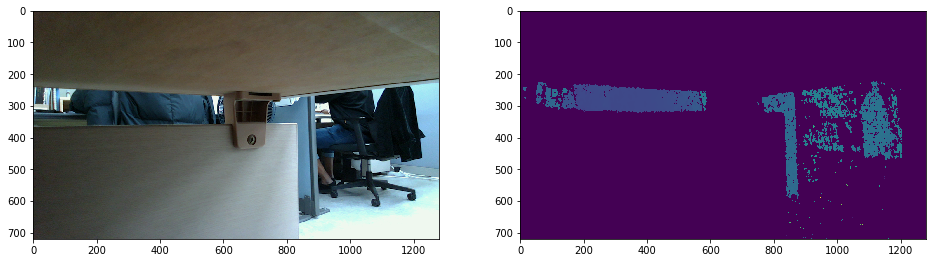

In [13]:
color_image, depth_image = micp.get_image()
plt.figure(figsize=(16,9))
plt.subplot(121)
plt.imshow(color_image[:,:,[2,1,0]]) # Transpose in the last dimension is for RGB-to-BGR conversion. (plt.imshow shows image in BGR order)
plt.subplot(122)
plt.imshow(depth_image)

In [14]:
# name = "cup"
# model = micp.model
# obj_center = (1,1,1.2)
# obj_rpy = (0,0,0)
# gscene.create_safe(gtype=GEOTYPE.MESH, name="{}_res".format(name), link_name="base_link",
#                    dims=(0.1,0.1,0.1), center=obj_center, rpy=obj_rpy,
#                    color=(0.8,0.8,0.8,1), display=True, fixed=True, collision=False,
#                    vertices=np.asarray(model.vertices), triangles=np.asarray(model.triangles))

##### Run shared detector for object detection on bash
```bash
python3 /home/jhkim/Projects/rnb-planning/src/pkg/detector/multiICP/shared_detector.py --dims='(720,1280,3)'
```

#### Clearing shared detector channels if zombie memory remains
```python
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")
```

In [15]:
from pkg.utils.shared_function import clear_channels_on, sa
clear_channels_on("SharedDetector")

In [16]:
from pkg.detector.multiICP.shared_detector import SharedDetectorGen
sd = SharedDetectorGen(micp.img_dim+(3,))()
sd.init()

##### detect()
* Object Detection through swin-transformer based mask rcnn using mmdet
* obj_name is name of object you want to detect, which follows coco dataset class
* Tc is camera transformation matrix w.r.t base coordinate.

In [17]:
def load_rdict(obj_type,
               intrins=[1280, 720,
                        909.957763671875, 909.90283203125,
                        638.3824462890625, 380.0085144042969],
               depth_scale=1 / 3999.999810010204):
    rdict = {}
    rdict['color'] = cv2.imread(
        os.path.join('/home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/save_img/',
                     obj_type + '.jpg'), flags=cv2.IMREAD_UNCHANGED)
    rdict['depth'] = cv2.imread(
        os.path.join('/home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/save_img/',
                     obj_type + '.png'), flags=cv2.IMREAD_UNCHANGED)
    rdict['intrins'], rdict['depth_scale'] = intrins, depth_scale
    Q = np.loadtxt(os.path.join('/home/jhkim/Projects/rnb-planning/src/scripts/milestone_202110/save_img/',
                                obj_type + '.csv'), delimiter=",")
    return rdict, np.array(Q)

In [18]:
rdict, Q = load_rdict("full_view")

In [19]:
color_img = rdict['color']
depth_img = rdict['depth']
Tc = viewpoint.get_tf(Q)
gscene.show_pose(Q)

In [20]:
pose_dict = micp.detect(sd, color_img, depth_img, Tc, visualize=True)

===== Detected : handbag, 1 object(s) =====
===== Detected : suitcase, 1 object(s) =====
===== Detected : bowl, 1 object(s) =====
===== Detected : bed, 1 object(s) =====
===== Detected : clock, 1 object(s) =====
Apply point-to-point ICP
registration::RegistrationResult with fitness=8.419387e-01, inlier_rmse=6.922927e-02, and correspondence_set size of 5055
Access transformation to get result.
Transformation is:
[[ 0.82077101 -0.10872055  0.56081623 -0.58764322]
 [-0.22994232 -0.96155648  0.15011874  0.66425807]
 [ 0.5229355  -0.25216848 -0.81421713  4.62481914]
 [ 0.          0.          0.          1.        ]]
Found 6DoF pose of bed_00
===== Apply heuristic rule for closet =====
CLOSET ON LEFT
Number of points 16687
Apply point-to-point ICP
registration::RegistrationResult with fitness=7.725576e-01, inlier_rmse=4.543963e-02, and correspondence_set size of 18417
Access transformation to get result.
Transformation is:
[[-0.99855212  0.0199183   0.0499699   5.80147401]
 [ 0.05052335  0.

##### show on Rviz

In [37]:
Tbc = SE3(np.identity(3), (0,0,0))

In [38]:
pcd = micp.pcd
gscene.create_safe(GEOTYPE.MESH, "pcd", "base_link", (0.1,0.1,0.1), (0,0,0), rpy=(0,0,0), color=(1,0,0,1), display=True,
                   collision=False, fixed=True, scale=(0.01,0.01,1),
                   vertices=np.matmul(np.asarray(pcd.points), Tbc[:3,:3].transpose())+Tbc[:3,3])

[WARN] Vertices for mesh should be have center point (0,0,0). Auto adjusting.


##### compute_ICP()
* Initial guess is cruical for ICP
* Manual Initialization is needed to compute ICP well

In [39]:
Tguess = micp.get_initial_by_center(R=Rot_axis(1,np.pi/2),
                                        offset=(0.0,0,0.0))
ICP_result, fitness = micp.compute_ICP(To=Tguess, visualize=True)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.509968e-02, and correspondence_set size of 12485
Access transformation to get result.
Transformation is:
[[ 0.99930935  0.02409145  0.02829193 -0.02631322]
 [ 0.02880117 -0.02106007 -0.99936328  0.11347948]
 [-0.02348028  0.99948791 -0.02173939  0.55053717]
 [ 0.          0.          0.          1.        ]]


##### update at gsene

In [31]:
gtem = add_object(gscene, 'cup', ICP_result[:3,3], Rot2rpy(ICP_result[:3,:3]), (0,1,0,0.5))

##### compute_front_ICP()

In [31]:
ICP_result, fitness = micp.compute_front_ICP(visualize=True)

Apply point-to-point ICP
registration::RegistrationResult with fitness=1.000000e+00, inlier_rmse=1.120181e-02, and correspondence_set size of 7835
Access transformation to get result.
Transformation is:
[[ 0.98817746 -0.15291306  0.01108604 -0.02265138]
 [ 0.0080556  -0.02042342 -0.99975897  0.11835813]
 [ 0.15310262  0.98802858 -0.01895016  0.56058038]
 [ 0.          0.          0.          1.        ]]


##### update at gscene

In [19]:
gtem = add_object(gscene, 'cup', ICP_result[:3,3], Rot2rpy(ICP_result[:3,:3]), (0,1,0,0.5))

##### check geometry()

In [20]:
print("Detect by Levels")
print("Environments: {}".format(micp.get_targets_of_levels(gscene, DetectionLevel.ENVIRONMENT)))
print("Movable Objects: {}".format(micp.get_targets_of_levels(gscene, DetectionLevel.MOVABLE)))

Detect by Levels
Environments: []
Movable Objects: ['cup']


##### get pose()

In [21]:
print("Detect by Names")
print("{}: {}".format('cup', micp.get_pose('cup')))

Detect by Names
cup: [[ 0.66469009  0.71242562  0.22502627  0.03667995]
 [-0.3111956   0.53782571 -0.78351822  0.11671659]
 [-0.67922337  0.45076961  0.57919114  0.66397102]
 [ 0.          0.          0.          1.        ]]


##### disconnect()

In [19]:
micp.disconnect()